In [4]:
%matplotlib inline

In [5]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)


import argparse
import datetime
import random

import backtrader as bt


class St(bt.Strategy):
    params = (
        ('printout', False),
        ('stake', 1000),
    )

    def __init__(self):
        pass

    def start(self):
        if self.p.printout:
            txtfields = list()
            txtfields.append('Len')
            txtfields.append('Datetime')
            txtfields.append('Open')
            txtfields.append('High')
            txtfields.append('Low')
            txtfields.append('Close')
            txtfields.append('Volume')
            txtfields.append('OpenInterest')
            print(','.join(txtfields))

    def next(self):
        if self.p.printout:
            # Print only 1st data ... is just a check that things are running
            txtfields = list()
            txtfields.append('%04d' % len(self))
            txtfields.append(self.data.datetime.datetime(0).isoformat())
            txtfields.append('%.2f' % self.data0.open[0])
            txtfields.append('%.2f' % self.data0.high[0])
            txtfields.append('%.2f' % self.data0.low[0])
            txtfields.append('%.2f' % self.data0.close[0])
            txtfields.append('%.2f' % self.data0.volume[0])
            txtfields.append('%.2f' % self.data0.openinterest[0])
            print(','.join(txtfields))

        # Data 0
        for data in self.datas:
            toss = random.randint(1, 10)
            curpos = self.getposition(data)
            if curpos.size:
                if toss > 5:
                    size = curpos.size // 2
                    self.sell(data=data, size=size)
                    if self.p.printout:
                        print('SELL {} @%{}'.format(size, data.close[0]))

            elif toss < 5:
                self.buy(data=data, size=self.p.stake)
                if self.p.printout:
                    print('BUY  {} @%{}'.format(self.p.stake, data.close[0]))


def runstrat(args=None):
    args = parse_args(args)

    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(args.cash)

    dkwargs = dict()
    if args.fromdate:
        fromdate = datetime.datetime.strptime(args.fromdate, '%Y-%m-%d')
        dkwargs['fromdate'] = fromdate

    if args.todate:
        todate = datetime.datetime.strptime(args.todate, '%Y-%m-%d')
        dkwargs['todate'] = todate

    data0 = bt.feeds.BacktraderCSVData(dataname=args.data0, **dkwargs)
    cerebro.adddata(data0, name='Data0')

    data1 = bt.feeds.BacktraderCSVData(dataname=args.data1, **dkwargs)
    cerebro.adddata(data1, name='Data1')

    data2 = bt.feeds.BacktraderCSVData(dataname=args.data2, **dkwargs)
    cerebro.adddata(data2, name='Data2')

    cerebro.addstrategy(St, printout=args.printout)
    if not args.no_pyfolio:
        cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

    results = cerebro.run()
    if not args.no_pyfolio:
        strat = results[0]
        pyfoliozer = strat.analyzers.getbyname('pyfolio')

        returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
        if args.printout:
            print('-- RETURNS')
            print(returns)
            print('-- POSITIONS')
            print(positions)
            print('-- TRANSACTIONS')
            print(transactions)
            print('-- GROSS LEVERAGE')
            print(gross_lev)

        import pyfolio as pf
        pf.create_full_tear_sheet(
            returns,
            positions=positions,
            transactions=transactions,
            gross_lev=gross_lev,
            live_start_date='2005-05-01',
            round_trips=True)

    if args.plot:
        cerebro.plot(style=args.plot_style)


def parse_args(args=None):

    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
        description='Sample for pivot point and cross plotting')

    parser.add_argument('--data0', required=False,
                        default='../../datas/yhoo-1996-2015.txt',
                        help='Data to be read in')

    parser.add_argument('--data1', required=False,
                        default='../../datas/orcl-1995-2014.txt',
                        help='Data to be read in')

    parser.add_argument('--data2', required=False,
                        default='../../datas/nvda-1999-2014.txt',
                        help='Data to be read in')

    parser.add_argument('--fromdate', required=False,
                        default='2005-01-01',
                        help='Starting date in YYYY-MM-DD format')

    parser.add_argument('--todate', required=False,
                        default='2006-12-31',
                        help='Ending date in YYYY-MM-DD format')

    parser.add_argument('--printout', required=False, action='store_true',
                        help=('Print data lines'))

    parser.add_argument('--cash', required=False, action='store',
                        type=float, default=50000,
                        help=('Cash to start with'))

    parser.add_argument('--plot', required=False, action='store_true',
                        help=('Plot the result'))

    parser.add_argument('--plot-style', required=False, action='store',
                        default='bar', choices=['bar', 'candle', 'line'],
                        help=('Plot style'))

    parser.add_argument('--no-pyfolio', required=False, action='store_true',
                        help=('Do not do pyfolio things'))

    import sys
    aargs = args if args is not None else sys.argv[1:]
    return parser.parse_args(aargs)

Entire data start date: 2005-01-03
Entire data end date: 2006-12-29


Out-of-Sample Months: 20
Backtest Months: 3


Performance statistics,All history,Backtest,Out of sample
annual_return,0.13,0.01,0.15
annual_volatility,0.13,0.13,0.13
sharpe_ratio,1.02,0.17,1.19
calmar_ratio,1.19,0.29,1.42
stability_of_timeseries,0.94,0.18,0.95
max_drawdown,-0.11,-0.05,-0.11
omega_ratio,1.29,1.04,1.35
sortino_ratio,1.63,0.26,1.91
skew,0.53,0.57,0.53
kurtosis,13.97,5.91,15.41


Worst Drawdown Periods,net drawdown in %,peak date,valley date,recovery date,duration
0,10.90,2006-04-06,2006-06-13,2006-10-26,146
1,7.28,2005-04-21,2005-06-27,2005-10-31,138
2,6.75,2005-11-25,2005-12-30,2006-01-11,34
3,4.62,2005-01-18,2005-02-09,2005-02-18,24
4,3.12,2006-11-30,2006-12-26,NaT,NaN




[-0.016 -0.036]


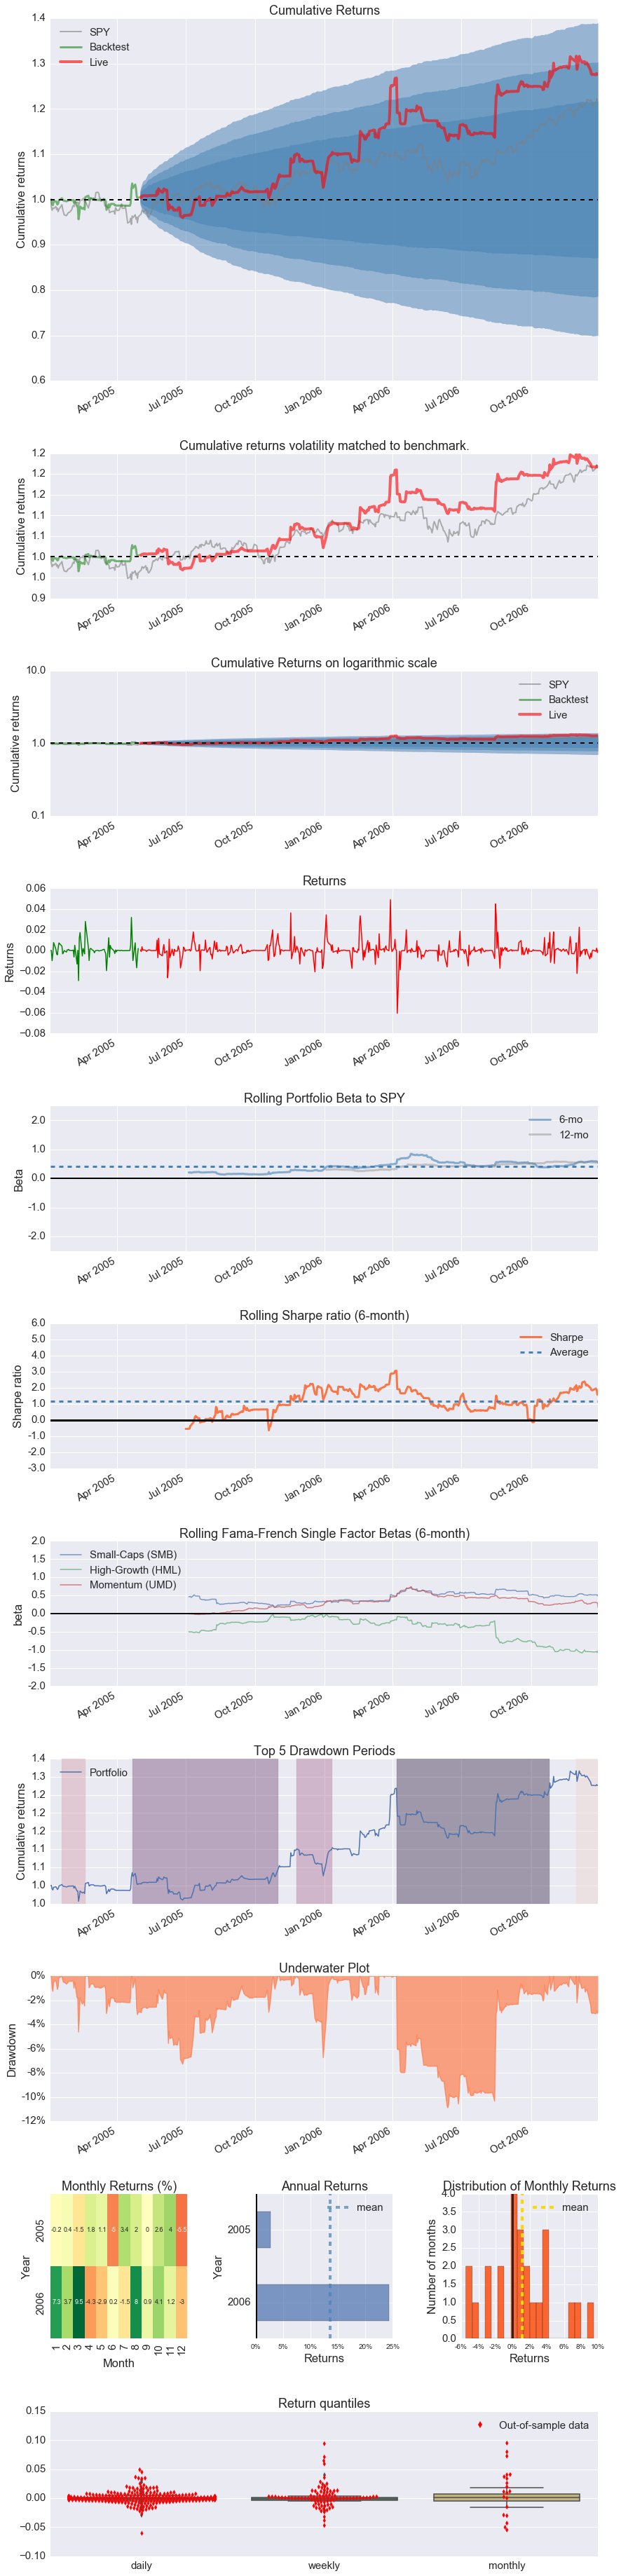

Stress Events,mean,min,max
Low Volatility Bull Market,0.05%,-6.05%,4.91%


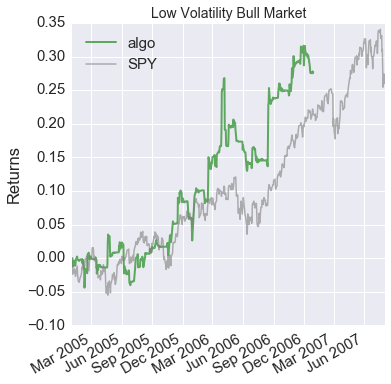

Top 10 long positions of all time,max
Data2,91.56%
Data0,77.49%
Data1,30.45%


Top 10 short positions of all time,max


Top 10 positions of all time,max
Data2,91.56%
Data0,77.49%
Data1,30.45%


All positions ever held,max
Data2,91.56%
Data0,77.49%
Data1,30.45%


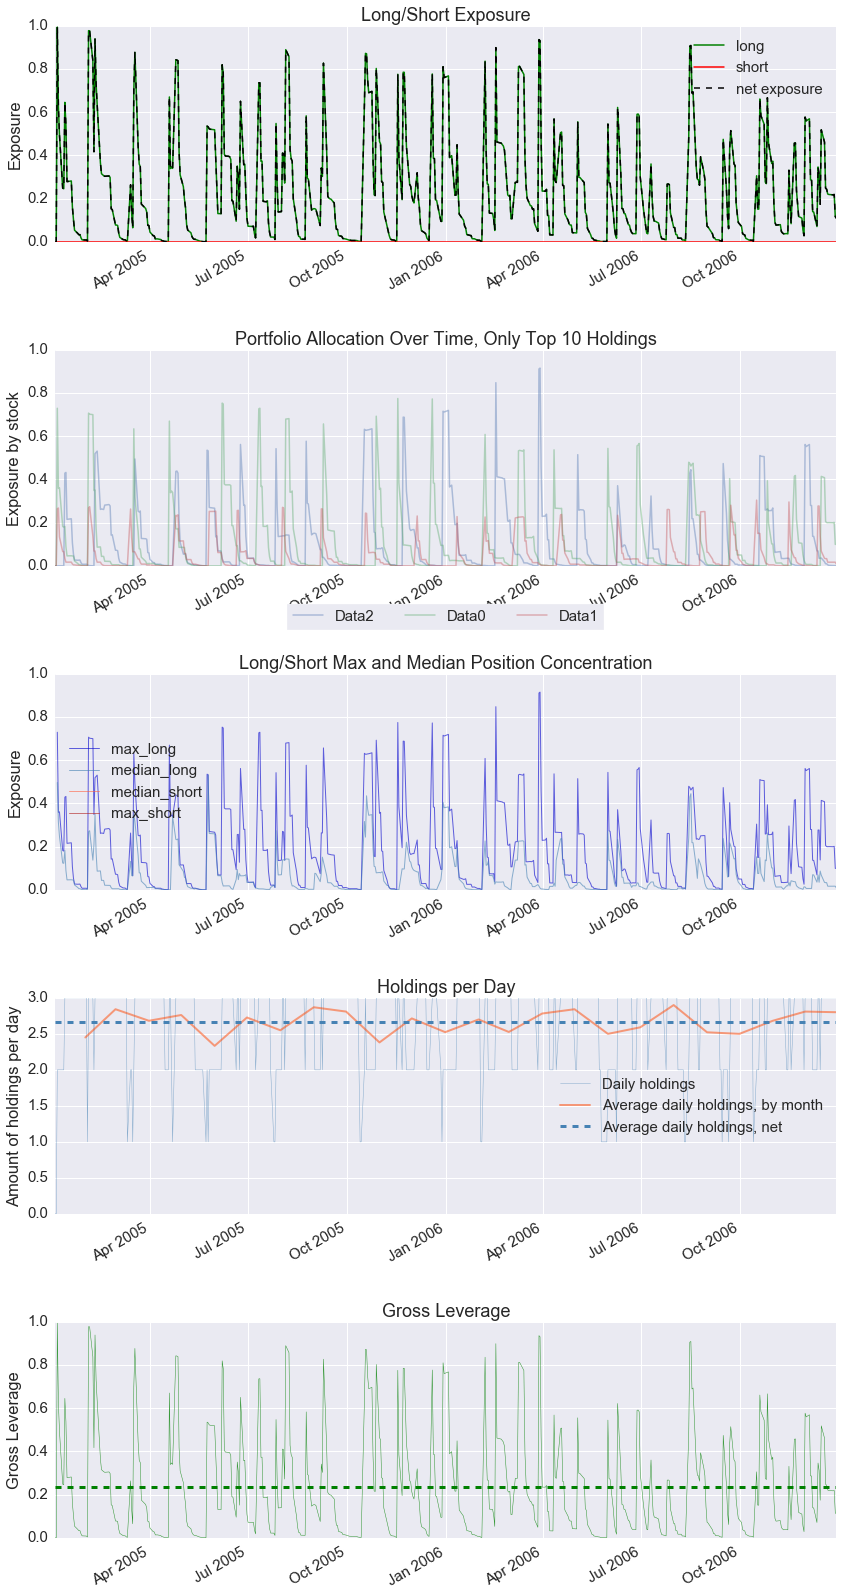

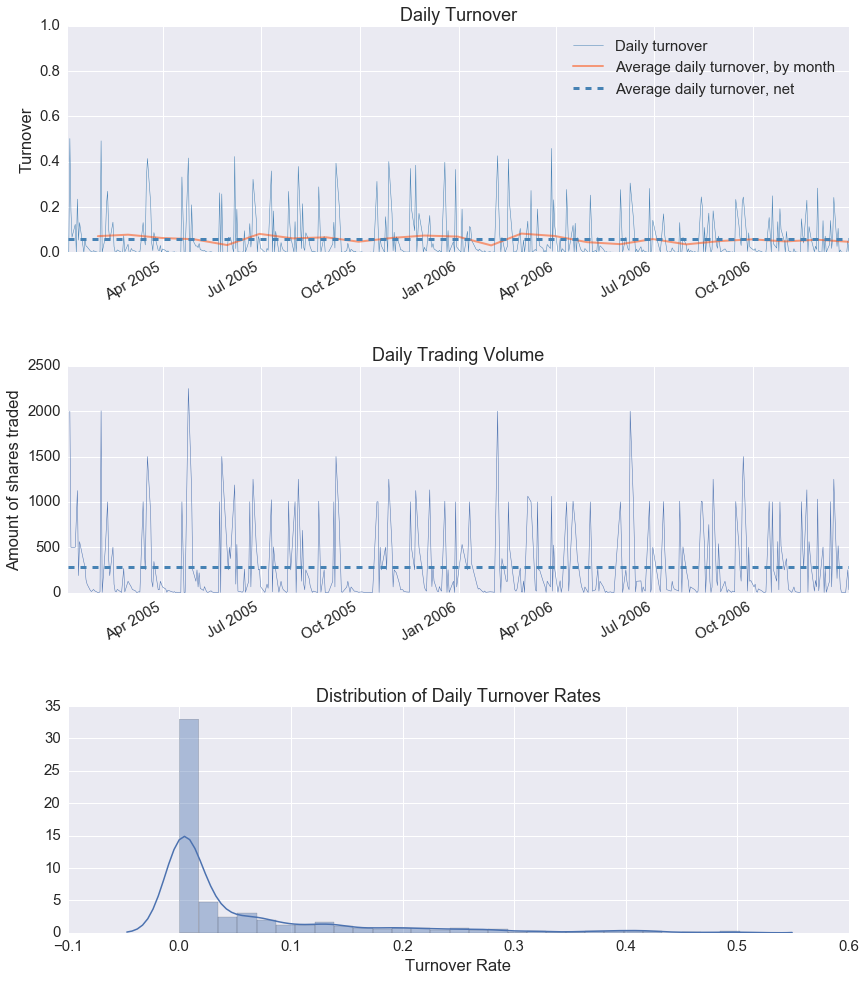

Summary stats,All trades,Long trades
Total number of round_trips,668.00,668.00
Percent profitable,0.55,0.55
Winning round_trips,365.00,365.00
Losing round_trips,301.00,301.00
Even round_trips,2.00,2.00


PnL stats,All trades,Long trades
Total profit,$13825.01,$13825.01
Gross profit,$33970.19,$33970.19
Gross loss,$-20145.17,$-20145.17
Profit factor,$1.69,$1.69
Avg. trade net profit,$20.70,$20.70
Avg. winning trade,$93.07,$93.07
Avg. losing trade,$-66.93,$-66.93
Ratio Avg. Win:Avg. Loss,$1.39,$1.39
Largest winning trade,$2425.01,$2425.01
Largest losing trade,$-1403.06,$-1403.06


Duration stats,All trades,Long trades
Avg duration,17 days 06:28:01.440119,17 days 06:28:01.440119
Median duration,17 days 00:00:00,17 days 00:00:00
Avg # round_trips per day,13.63,13.63
Avg # round_trips per month,286.29,286.29


Return stats,All trades,Long trades
Avg returns all round_trips,0.04%,0.04%
Avg returns winning,0.17%,0.17%
Avg returns losing,-0.12%,-0.12%
Median returns all round_trips,0.00%,0.00%
Median returns winning,0.03%,0.03%
Median returns losing,-0.03%,-0.03%
Largest winning trade,4.36%,4.36%
Largest losing trade,-2.21%,-2.21%


Symbol stats,Data0,Data1,Data2
Avg returns all round_trips,0.01%,0.01%,0.10%
Avg returns winning,0.19%,0.04%,0.24%
Avg returns losing,-0.15%,-0.03%,-0.20%
Median returns all round_trips,-0.00%,0.00%,0.01%
Median returns winning,0.03%,0.01%,0.04%
Median returns losing,-0.03%,-0.01%,-0.06%
Largest winning trade,2.02%,0.34%,4.36%
Largest losing trade,-1.95%,-0.27%,-2.21%


Profitability (PnL / PnL total) per name,pnl
symbol,
Data2,0.89%
Data0,0.06%
Data1,0.06%


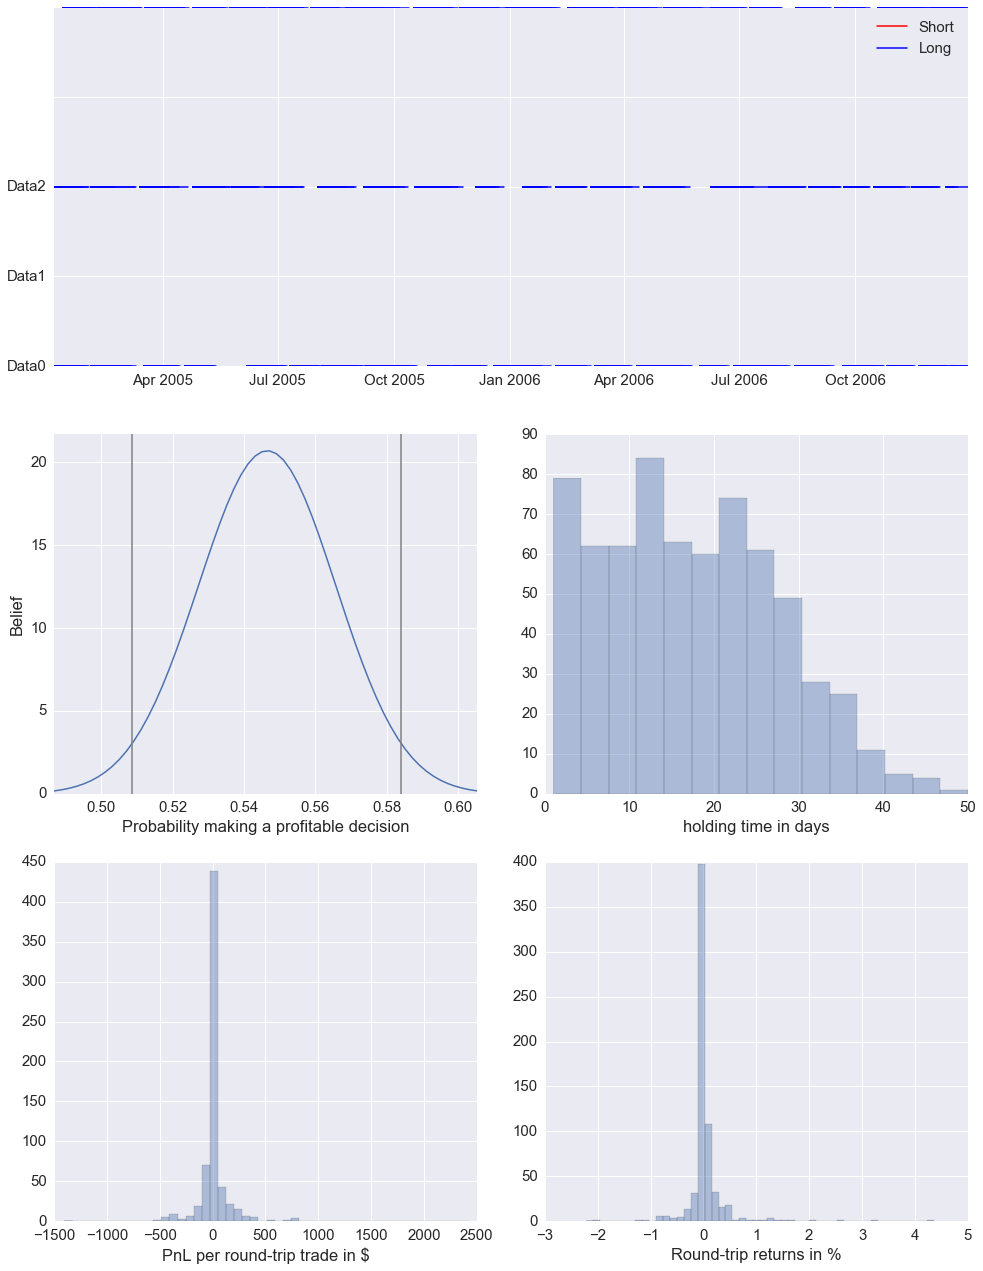

In [6]:
runstrat([])